# 1. Import Libraries

In [21]:
import os
import pandas as pd
import numpy as np
import pyodbc

# 2. Connection to SQL Server

In [22]:
conn = pyodbc.connect(
    "DRIVER={SQL Server};"
    "SERVER=LAPTOP-G3F50P50\MSSQLSERVER03;"
    "DATABASE=THCK;"
    "Trusted_Connection=yes;")
df = pd.read_sql_query(
    """
    SELECT *
    FROM [THCK].[dbo].[Airline_Processed];
    """,conn)
df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17648\541867857.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


,Passenger_ID,First_Name,Last_Name,Gender,Age,Nationality,Airport_Name,Airport_Country_Code,Country_Name,Continents,...,load_date,dep_year,dep_month,dep_month_name,dep_weekday,is_delayed,is_cancelled,flight_status_group,age_group,continent_group
0,j3Y5Po,Alison,Caesman,Female,65,China,Bazhong Enyang Airport,CN,China,Asia,...,2026-01-26,2022,1,January,Tuesday,0,0,OnTime,60+,Asia
1,zDEwOE,Artus,Timbrell,Male,36,Philippines,Syangboche Airport,NP,Nepal,Asia,...,2026-01-26,2022,9,September,Thursday,0,1,Issue,36-60,Asia
2,lDQYQJ,Ram,Greatex,Male,3,Montenegro,Sim Airport,PG,Papua New Guinea,Oceania,...,2026-01-26,2022,4,April,Friday,1,0,Issue,Under 18,Oceania
3,nKDtL3,Hewett,Gallichiccio,Male,19,Canada,West Angelas Airport,AU,Australia,Oceania,...,2026-01-26,2022,7,July,Friday,1,0,Issue,18-35,Oceania
4,as6oao,Lynne,Totman,Female,30,China,Mc Cook Ben Nelson Regional Airport,US,United States,North America,...,2026-01-26,2022,5,May,Thursday,1,0,Issue,18-35,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98614,2VAJ5D,Hakeem,Dyball,Male,1,China,Teniente Vidal Airport,CL,Chile,South America,...,2026-01-26,2022,1,January,Wednesday,1,0,Issue,Under 18,South America
98615,KZzonB,Barbabas,Despenser,Male,33,Norway,Soewondo Air Force Base,ID,Indonesia,Asia,...,2026-01-26,2022,3,March,Friday,0,1,Issue,18-35,Asia
98616,278krt,Robby,Booley,Male,36,Uganda,Santo Ângelo Airport,BR,Brazil,South America,...,2026-01-26,2022,8,August,Friday,0,1,Issue,36-60,South America
98617,xloUKD,Flin,Schild,Male,26,Pakistan,Jalalabad Airport,AF,Afghanistan,Asia,...,2026-01-26,2022,1,January,Saturday,0,1,Issue,18-35,Asia


# 3. Preprocessing Data

## 3.1 Check missing values

In [23]:
df.isnull().sum()

Passenger_ID            0
First_Name              0
Last_Name               0
Gender                  0
Age                     0
Nationality             0
Airport_Name            0
Airport_Country_Code    0
Country_Name            0
Continents              0
Departure_Date          0
Arrival_Airport         0
Pilot_Name              0
Flight_Status           0
load_date               0
dep_year                0
dep_month               0
dep_month_name          0
dep_weekday             0
is_delayed              0
is_cancelled            0
flight_status_group     0
age_group               0
continent_group         0
dtype: int64

The dataset contains no missing values across all key variables, ensuring high data quality and allowing reliable analysis and modeling without additional data cleaning.

## 3.2 Check duplicate rows

In [24]:
df.duplicated().sum()

np.int64(0)

No duplicate records were detected in the dataset, ensuring each observation represents a unique flight and preventing bias from duplicated entries in analysis and modeling.

## 3.3 Ensure correct data types

In [25]:
df['Departure_Date'] = pd.to_datetime(df['Departure_Date'])
df['Age'] = df['Age'].astype(int)
df['is_delayed'] = df['is_delayed'].astype(int)
df['is_cancelled'] = df['is_cancelled'].astype(int)

## 3.4 Validate business logic

In [26]:
# Validate flight status vs flags
df[['Flight_Status', 'is_delayed', 'is_cancelled']].value_counts()

Flight_Status  is_delayed  is_cancelled
Cancelled      0           1               32942
On Time        0           0               32846
Delayed        1           0               32831
Name: count, dtype: int64

This consistency validates the reliability of engineered target variables, ensuring that downstream analysis and predictive models are based on correct business logic.

In [27]:
# Validate segmentation logic
df['age_group'].value_counts()
df['continent_group'].value_counts()

continent_group
North America    32033
Asia             18637
Oceania          13866
Europe           12335
Africa           11030
South America    10718
Name: count, dtype: int64

The continent segmentation is well-distributed and logically structured, with flight records spanning all major regions, supporting robust geographic analysis and comparison.

## 3.5 Outlier check

In [28]:
df['Age'].describe()

count    98619.000000
mean        45.504021
std         25.929849
min          1.000000
25%         23.000000
50%         46.000000
75%         68.000000
max         90.000000
Name: Age, dtype: float64

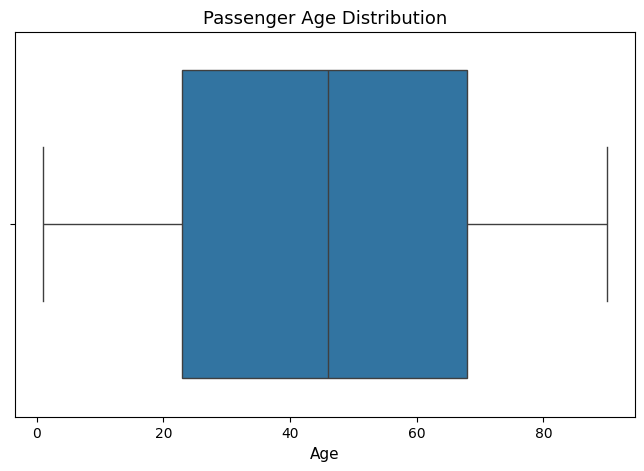

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['Age'])
plt.title("Passenger Age Distribution")
plt.show()


No unrealistic age outliers were identified, supporting data reliability.

## 3.6 Create analytics-ready dataset

In [30]:
analysis_cols = [
    'Passenger_ID',
    'Gender',
    'Age',
    'age_group',
    'Nationality',
    'Airport_Name',
    'Country_Name',
    'continent_group',
    'Departure_Date',
    'dep_month',
    'dep_month_name',
    'dep_weekday',
    'Flight_Status',
    'is_delayed',
    'is_cancelled']
df_analysis = df[analysis_cols].copy()
df_analysis.head()


,Passenger_ID,Gender,Age,age_group,Nationality,Airport_Name,Country_Name,continent_group,Departure_Date,dep_month,dep_month_name,dep_weekday,Flight_Status,is_delayed,is_cancelled
0,j3Y5Po,Female,65,60+,China,Bazhong Enyang Airport,China,Asia,2022-01-04,1,January,Tuesday,On Time,0,0
1,zDEwOE,Male,36,36-60,Philippines,Syangboche Airport,Nepal,Asia,2022-09-22,9,September,Thursday,Cancelled,0,1
2,lDQYQJ,Male,3,Under 18,Montenegro,Sim Airport,Papua New Guinea,Oceania,2022-04-08,4,April,Friday,Delayed,1,0
3,nKDtL3,Male,19,18-35,Canada,West Angelas Airport,Australia,Oceania,2022-07-01,7,July,Friday,Delayed,1,0
4,as6oao,Female,30,18-35,China,Mc Cook Ben Nelson Regional Airport,United States,North America,2022-05-12,5,May,Thursday,Delayed,1,0


A clean, well-structured dataset was prepared to support efficient analysis and visualization.

# 4. Exploratory data analysis

In [31]:
import matplotlib.pyplot as plt

# Color palette chuẩn BI / doanh nghiệp
COLOR_GOOD = '#2ca02c'      # xanh lá
COLOR_WARN = '#ff7f0e'      # cam
COLOR_BAD  = '#d62728'      # đỏ
COLOR_NEUTRAL = '#1f77b4'   # xanh dương

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

## 4.1 Overall flight performance

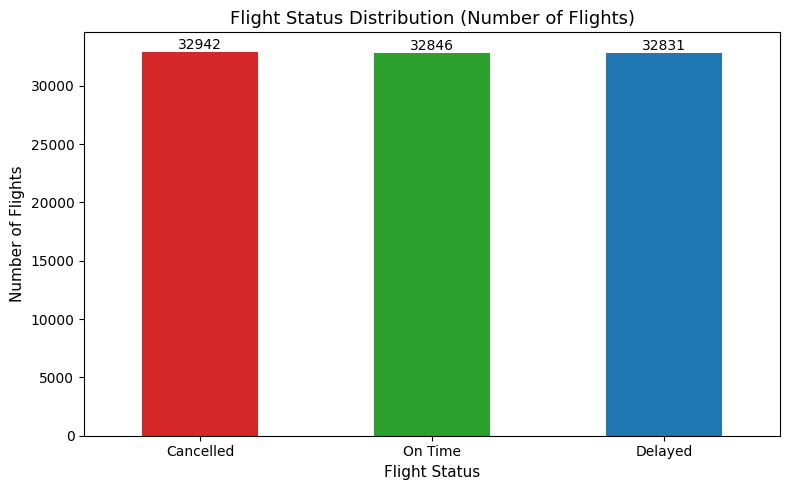

In [32]:
# Count số lượng chuyến bay theo trạng thái
status_count = df_analysis['Flight_Status'].value_counts()
# Định nghĩa màu theo ý nghĩa business
color_map = {
    'On Time': '#2ca02c',     
    'Delayed': '#1f77b4',     
    'Cancelled': '#d62728'    }
# Ánh xạ màu theo thứ tự index
colors = [color_map.get(status, '#7f7f7f') for status in status_count.index]
# Vẽ biểu đồ
ax = status_count.plot(
    kind='bar',
    color=colors)
# Trang trí biểu đồ
plt.title("Flight Status Distribution (Number of Flights)")
plt.xlabel("Flight Status")
plt.ylabel("Number of Flights")
plt.xticks(rotation=0)
# Hiển thị label số lượng trên mỗi cột
for i, v in enumerate(status_count.values):
    ax.text(i, v, f"{v}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

Flight outcomes are evenly distributed across On Time, Delayed, and Cancelled, indicating no extreme class dominance.
This provides a balanced view of operational performance.

## 4.2 Delay rate by continent

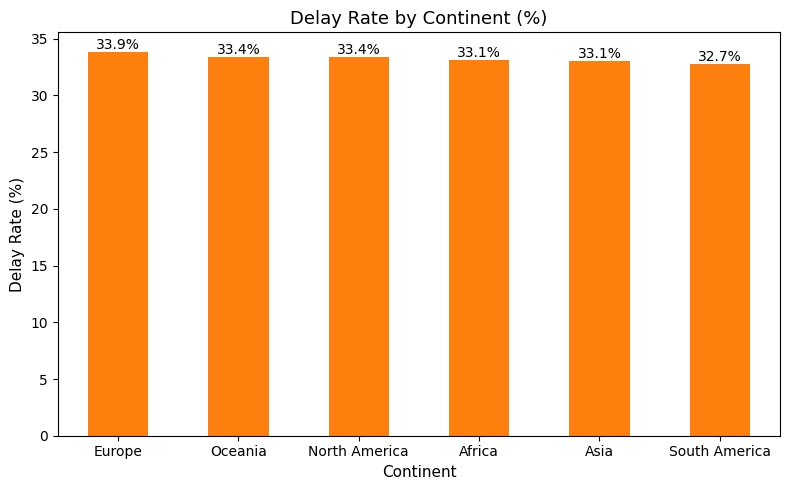

In [33]:
delay_by_continent = (
    df_analysis
    .groupby('continent_group')['is_delayed']
    .mean()
    .sort_values(ascending=False) * 100)
ax = delay_by_continent.plot(
    kind='bar',
    color=COLOR_WARN)
plt.title("Delay Rate by Continent (%)")
plt.xlabel("Continent")
plt.ylabel("Delay Rate (%)")
plt.xticks(rotation=0)

# Label %
for i, v in enumerate(delay_by_continent.values):
    ax.text(i, v, f"{v:.1f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()

Delay rates are relatively consistent across continents, ranging from ~32.7% to ~33.9%.
This suggests delays are driven more by global operational factors than by geography alone.

## 4.3 Delay trend by month

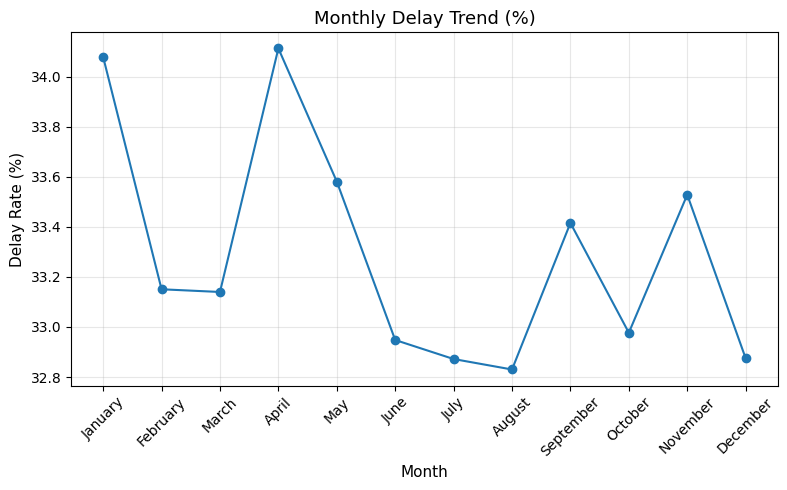

In [34]:
delay_by_month = (
    df_analysis
    .groupby(['dep_month', 'dep_month_name'])['is_delayed']
    .mean()
    .reset_index()
    .sort_values('dep_month'))
plt.plot(
    delay_by_month['dep_month_name'],
    delay_by_month['is_delayed'] * 100,
    marker='o',
    color=COLOR_NEUTRAL)
plt.title("Monthly Delay Trend (%)")
plt.xlabel("Month")
plt.ylabel("Delay Rate (%)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Delay rates peak in April (~34.5%) and January (~34.2%), while the lowest levels occur in August (~32.8%) and July (~32.9%).
This indicates mild seasonality, potentially linked to demand peaks or weather conditions.

## 4.4 Delay by passenger age group

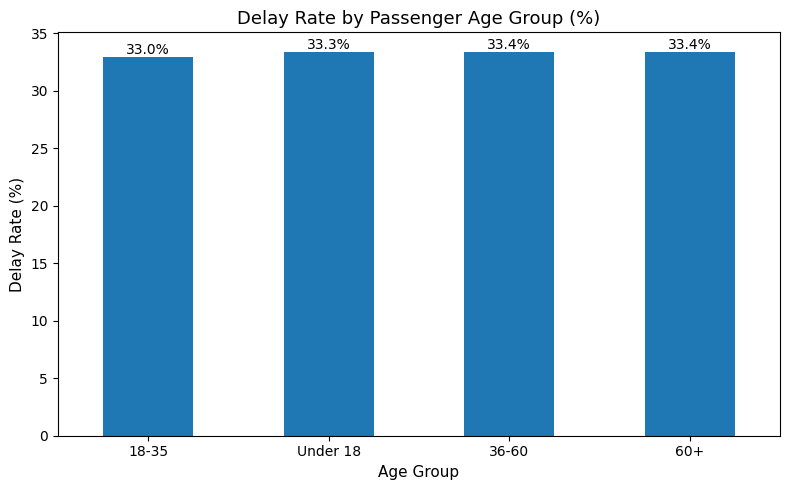

In [35]:
delay_by_age = (
    df_analysis
    .groupby('age_group')['is_delayed']
    .mean()
    .sort_values() * 100)
ax = delay_by_age.plot(
    kind='bar',
    color=COLOR_NEUTRAL)
plt.title("Delay Rate by Passenger Age Group (%)")
plt.xlabel("Age Group")
plt.ylabel("Delay Rate (%)")
plt.xticks(rotation=0)
for i, v in enumerate(delay_by_age.values):
    ax.text(i, v, f"{v:.1f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()

Delay rates are nearly identical across all age groups (~33%), indicating passenger age is not a significant driver of delays.

## 4.5 Top airports contributing to delays

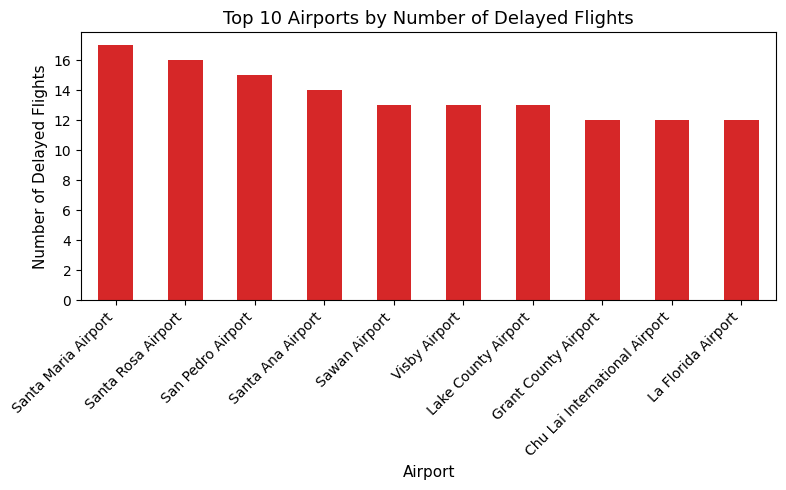

In [36]:
airport_delay = (
    df_analysis
    .groupby('Airport_Name')['is_delayed']
    .agg(
        total_flights='count',
        delayed_flights='sum')
    .reset_index())
airport_delay['delay_rate'] = (
    airport_delay['delayed_flights'] /
    airport_delay['total_flights'])
top_airports = airport_delay.sort_values(
    'delayed_flights',
    ascending=False
).head(10)
ax = top_airports.plot(
    x='Airport_Name',
    y='delayed_flights',
    kind='bar',
    color=COLOR_BAD,
    legend=False)
plt.title("Top 10 Airports by Number of Delayed Flights")
plt.xlabel("Airport")
plt.ylabel("Number of Delayed Flights")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

A small group of airports contributes disproportionately to total flight delays.
Santa Maria Airport and Santa Rosa Airport record the highest number of delayed flights, clearly standing out from the rest.

This concentration suggests that targeted operational improvements at a few high-impact airports could significantly reduce overall delay volumes, rather than applying broad, system-wide interventions.

# 5.preprocessing

## 5.1 Feature Selection

In [ ]:
model_cols = [
    'Age',
    'Gender',
    'age_group',
    'continent_group',
    'dep_month',
    'dep_weekday']
df_model = df_analysis[model_cols + ['is_delayed']].copy()
df_model.head()

,Age,Gender,age_group,continent_group,dep_month,dep_weekday,is_delayed
0,65,Female,60+,Asia,1,Tuesday,0
1,36,Male,36-60,Asia,9,Thursday,0
2,3,Male,Under 18,Oceania,4,Friday,1
3,19,Male,18-35,Oceania,7,Friday,1
4,30,Female,18-35,North America,5,Thursday,1


The selected features focus on passenger profile (Age, Gender, Age Group) and temporal & geographic context (Month, Weekday, Continent).
These variables are logically aligned with operational delay drivers and provide a strong, interpretable foundation for modeling flight delays.

## 5.2 Encode Categorical Variables

In [41]:
df_model_encoded = pd.get_dummies(
    df_model,
    columns=['Gender', 'age_group', 'continent_group', 'dep_weekday'],
    drop_first=True)
df_model_encoded.head()

,Age,dep_month,is_delayed,Gender_Male,age_group_36-60,age_group_60+,age_group_Under 18,continent_group_Asia,continent_group_Europe,continent_group_North America,continent_group_Oceania,continent_group_South America,dep_weekday_Monday,dep_weekday_Saturday,dep_weekday_Sunday,dep_weekday_Thursday,dep_weekday_Tuesday,dep_weekday_Wednesday
0,65,1,0,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False
1,36,9,0,True,True,False,False,True,False,False,False,False,False,False,False,True,False,False
2,3,4,1,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False
3,19,7,1,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,30,5,1,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False


Categorical variables were successfully transformed using one-hot encoding with drop_first=True, reducing multicollinearity while preserving essential information.
The resulting dataset is fully numerical and ready for machine learning algorithms.

## 5.3 Train – Test Split

In [42]:
from sklearn.model_selection import train_test_split

X = df_model_encoded.drop(columns='is_delayed')
y = df_model_encoded['is_delayed']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y)


In [43]:
X_train.shape, X_test.shape

((78895, 17), (19724, 17))

The dataset was split into 80% training (78895 records) and 20% testing (19724 records) using stratified sampling.
This ensures the class distribution of delayed vs. non-delayed flights is preserved across both sets, enabling reliable and unbiased model evaluation.

# 6.Model Training

## 6.1 Logistic Regression (Baseline)

In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

## 6.2 Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


## 6.3 Gradient Boosting

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]


# 7. Model evaluation

## 7.1 Evaluation Metrics

In [48]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score)
def evaluate_model(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)}

## 7.2 Model Comparison

In [49]:
import pandas as pd

results = pd.DataFrame(
    [
        evaluate_model(y_test, y_pred_lr, y_prob_lr),
        evaluate_model(y_test, y_pred_rf, y_prob_rf),
        evaluate_model(y_test, y_pred_gb, y_prob_gb)],
    index=[
        "Logistic Regression",
        "Random Forest",
        "Gradient Boosting"])

results


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Logistic Regression,0.501420,0.335812,0.508986,0.404649,0.501444
Random Forest,0.535591,0.336978,0.408316,0.369233,0.503197
Gradient Boosting,0.667055,0.333333,0.000152,0.000304,0.503202


**Logistic Regression**

- Achieves the highest Recall (0.51), meaning it detects the largest proportion of delayed flights.

- Overall accuracy is low (0.50), but the model is less biased toward the majority class.

- ROC-AUC ≈ 0.50, indicating limited separation power.

Insight:
Logistic Regression is the most suitable model for early risk identification, where missing delayed flights is more costly than false alerts.

**Random Forest**

- Slightly improves Accuracy (0.54) compared to Logistic Regression.

- Recall drops to 0.41, meaning fewer delayed flights are detected.

- ROC-AUC remains close to 0.50, showing minimal predictive improvement.

Insight:
Random Forest increases model complexity without delivering meaningful gains in delay detection.

**Gradient Boosting**

- Highest Accuracy (0.67) but near-zero Recall (0.0001).

- The model almost always predicts “Not Delayed”.

- ROC-AUC still ≈ 0.50, confirming no real learning.

Insight:
High accuracy is misleading and driven by class imbalance. The model is not operationally usable for delay prediction.

***Overall Model Insight***

- All models have ROC-AUC ≈ 0.5, equivalent to random guessing.

- Current features lack strong predictive signals for flight delays.

- Accuracy alone is not a reliable metric for this problem.

## 7.3 Confusion Matrix

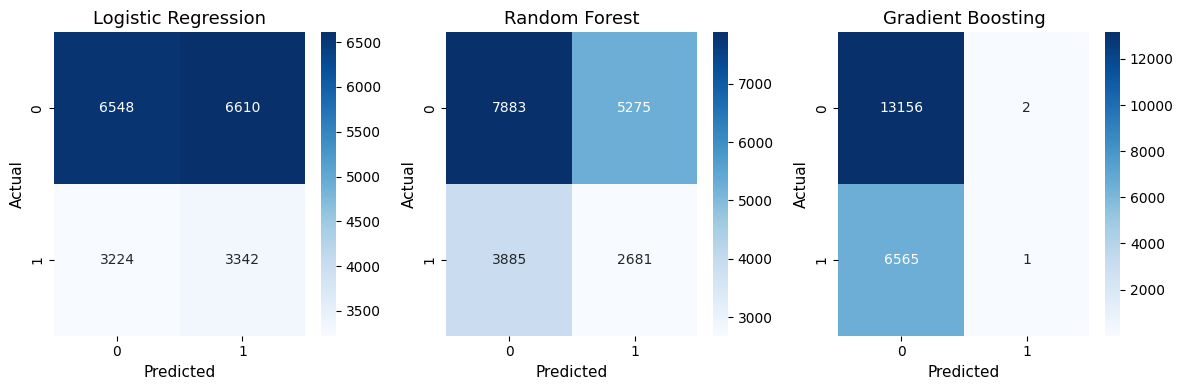

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb}

plt.figure(figsize=(12,4))
for i, (name, pred) in enumerate(models.items()):
    plt.subplot(1,3,i+1)
    sns.heatmap(
        confusion_matrix(y_test, pred),
        annot=True,
        fmt='d',
        cmap='Blues')
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


**Logistic Regression**

- Correctly identifies 3,342 delayed flights (True Positives).

- Misses 3,224 delayed flights (False Negatives).

- Generates a relatively high number of false alerts (6,610 False Positives).

Insight:
Logistic Regression provides the best balance between detecting delayed flights and operational risk. While it produces more false alarms, it minimizes the number of missed delays, making it suitable for early warning and risk monitoring use cases.

**Random Forest**

- Detects 2,681 delayed flights, fewer than Logistic Regression.

- Misses 3,885 delayed flights, indicating lower sensitivity.

- Produces fewer false positives than Logistic Regression.

Insight:
Random Forest is more conservative, reducing false alerts but at the cost of missing more delayed flights. This trade-off limits its usefulness in delay risk detection scenarios.

**Gradient Boosting**

- Correctly detects only 1 delayed flight.

- Misses 6,565 delayed flights, almost the entire delayed class.

- Almost always predicts flights as “Not Delayed”.

Insight:
Despite high overall accuracy, Gradient Boosting completely fails to identify delayed flights. The model is dominated by class imbalance and is not suitable for operational decision-making.

***Overall Conclusion***

- Logistic Regression is the most effective model for delay detection based on confusion matrix analysis.

- Accuracy alone is misleading for this problem; recall and error distribution are more critical.

- Current features lack strong predictive signals, highlighting the need for operational data to improve model performance.

## 7.4 ROC Curve

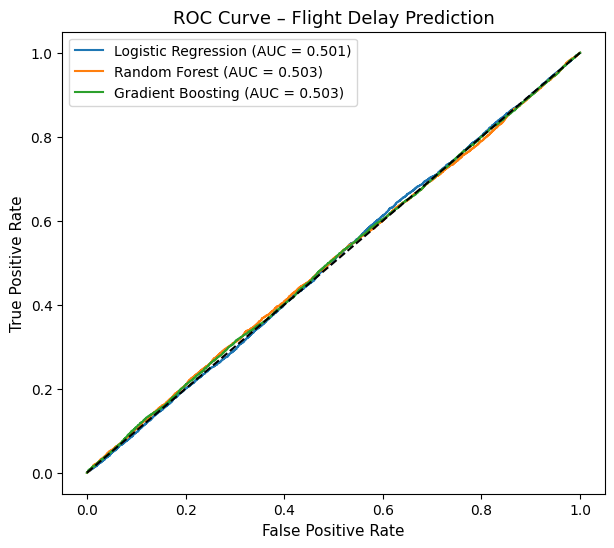

In [51]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(7,6))

for name, prob in zip(
    ["Logistic Regression", "Random Forest", "Gradient Boosting"],
    [y_prob_lr, y_prob_rf, y_prob_gb]):
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Flight Delay Prediction")
plt.legend()
plt.show()


**Key Observations**

- All three models (Logistic Regression, Random Forest, Gradient Boosting) have ROC-AUC ≈ 0.50–0.503.

- The ROC curves lie very close to the diagonal, which represents random guessing.

- There is no meaningful separation between delayed and non-delayed flights.

**Model-level Insight**

- Logistic Regression (AUC = 0.501)
Performs almost identically to random classification.
Indicates no strong linear relationship between selected features and flight delays.

- Random Forest (AUC = 0.503)
Slightly higher AUC but the improvement is negligible.
Non-linear modeling does not add predictive power with the current features.

- Gradient Boosting (AUC = 0.503)
Matches Random Forest performance but still fails to outperform randomness.
Model complexity does not compensate for weak input signals.

**Overall Conclusion**

- None of the models demonstrate real discriminative ability.

- Passenger demographics and basic time features are not sufficient to predict flight delays.

- The prediction problem is data-limited, not model-limited.